In [1]:
%pylab inline
from pylab import *

import mpl_toolkits.mplot3d
import os
import scipy.io

import path_utils
path_utils.add_relative_to_current_source_file_path_to_sys_path("../../../lib")

import flashlight.curve_utils         as curve_utils
import flashlight.spline_utils        as spline_utils
import flashlight.quadrotor_camera_3d as quadrotor_camera_3d

# ignore "Polyfit may be poorly conditioned" warnings, which occur when computing
# control trajectories with very small timesteps
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("../data/00"):  os.makedirs("../data/00")
if not os.path.exists("../plots/00"): os.makedirs("../plots/00")

Populating the interactive namespace from numpy and matplotlib
Initializing flashlight v0.0.1
flashlight.quadrotor_camera_3d: Constructing sympy symbols...
flashlight.quadrotor_camera_3d: Finished constructing sympy symbols (0.011 seconds).
flashlight.quadrotor_camera_3d: Loading sympy modules...
flashlight.quadrotor_camera_3d: Finished loading sympy modules (0.004 seconds).


/Users/mike/Code/GitHub/flashlight/code/lib/flashlight/transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


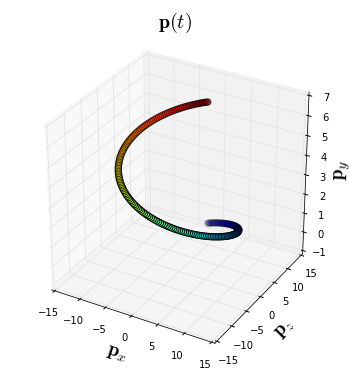

In [2]:
t_begin       = 0.0
t_end         = 2.0*pi
num_timesteps = 1000
t             = linspace(t_begin,t_end,num_timesteps)
dt            = (t_end-t_begin) / (num_timesteps-1)

p_x             = 10*cos(t)
p_y             = t
p_z             = 10*sin(t)
p_body_ground   = c_[ p_z, p_y, p_x ]
p_look_at       = c_[ zeros_like(t), zeros_like(t), zeros_like(t) ]
y_axis_cam_hint = c_[ zeros_like(t), ones_like(t),  zeros_like(t) ]

p_body = p_body_ground

scipy.io.savemat("../data/00/t.mat",             {"t":t},                  oned_as="column")
scipy.io.savemat("../data/00/p_body_ground.mat", {"p_body_ground":p_body}, oned_as="column")

figsize(6,6)
i = 5
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(p_body[::i,0], p_body[::i,2], p_body[::i,1], c=t[::i], cmap="jet", marker="o", s=40);
title("$\\mathbf{p}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

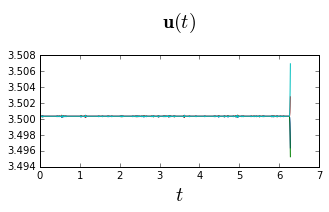

In [3]:
q_qdot_qdotdot = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_body, p_look_at, y_axis_cam_hint, dt)
u_ground       = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot, atol=1e-6)

u = u_ground

scipy.io.savemat("../data/00/u_ground.mat", {"u_ground":u_ground}, oned_as="column")

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);
gca().ticklabel_format(useOffset=False);

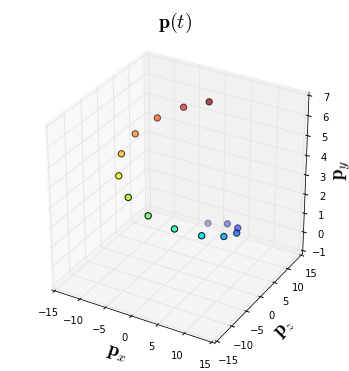

In [4]:
num_timesteps_sparse = 15
t_sparse             = linspace(t_begin,t_end,num_timesteps_sparse)

p_x = 10*cos(t_sparse)
p_y = t_sparse
p_z = 10*sin(t_sparse)
P   = c_[ p_z, p_y, p_x ]

scipy.io.savemat("../data/00/t_sparse.mat", {"t_sparse":t_sparse}, oned_as="column")

figsize(6,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(P[:,0], P[:,2], P[:,1], c=t_sparse, cmap="jet", marker="o", s=40);
title("$\\mathbf{p}(t)$\n", fontsize=20);
ax.set_zlabel("$\\mathbf{p}_y$", fontsize=20);
xlabel("$\\mathbf{p}_x$", fontsize=20); ylabel("$\\mathbf{p}_z$", fontsize=20);

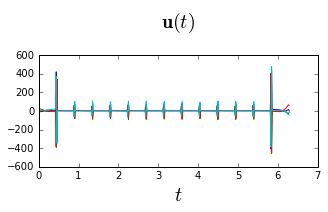

In [5]:
C,T,sd           = spline_utils.compute_catmull_rom_spline_coefficients(P,degree=3)
P_eval,T_eval,dT = spline_utils.evaluate_catmull_rom_spline(C,T,sd,num_samples=num_timesteps)
s                = linspace(0,1,num_timesteps)

P_eval_s, t_s, P_eval_s_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s)

p_body          = P_eval_s
q_qdot_qdotdot  = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_body, p_look_at, y_axis_cam_hint, dt)
u_catmull_rom_3 = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot)

u = u_catmull_rom_3

scipy.io.savemat("../data/00/u_catmull_rom_3.mat", {"u_catmull_rom_3":u_catmull_rom_3}, oned_as="column")

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);
gca().ticklabel_format(useOffset=False);

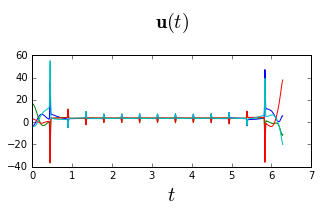

In [6]:
C,T,sd           = spline_utils.compute_nonlocal_interpolating_b_spline_coefficients(P,degree=3)
P_eval,T_eval,dT = spline_utils.evaluate_nonlocal_interpolating_b_spline(C,T,sd,num_samples=num_timesteps)
s                = linspace(0,1,num_timesteps)

P_eval_s, t_s, P_eval_s_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s)

p_body          = P_eval_s
q_qdot_qdotdot  = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_body, p_look_at, y_axis_cam_hint, dt)
u_natural_cubic = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot)

u = u_natural_cubic

scipy.io.savemat("../data/00/u_natural_cubic.mat", {"u_natural_cubic":u_natural_cubic}, oned_as="column")

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);
gca().ticklabel_format(useOffset=False);

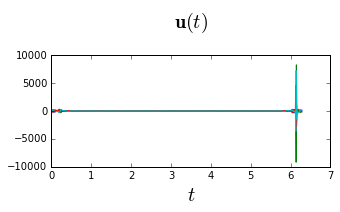

In [7]:
C,T,sd           = spline_utils.compute_catmull_rom_spline_coefficients(P,degree=9)
P_eval,T_eval,dT = spline_utils.evaluate_catmull_rom_spline(C,T,sd,num_samples=num_timesteps)
s                = linspace(0,1,num_timesteps)

P_eval_s, t_s, P_eval_s_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s)

p_body          = P_eval_s
q_qdot_qdotdot  = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_body, p_look_at, y_axis_cam_hint, dt)
u_catmull_rom_9 = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot, atol=1e-7)

u = u_catmull_rom_9

scipy.io.savemat("../data/00/u_catmull_rom_9.mat", {"u_catmull_rom_9":u_catmull_rom_9}, oned_as="column")

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);
gca().ticklabel_format(useOffset=False);

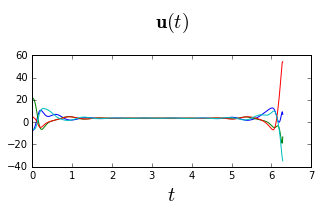

In [8]:
C,T,sd           = spline_utils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(P,degree=7,lamb=[0,0,0,1,0])
P_eval,T_eval,dT = spline_utils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(C,T,sd,num_samples=num_timesteps)
s                = linspace(0,1,num_timesteps)

P_eval_s, t_s, P_eval_s_cum_length, t_norm = curve_utils.reparameterize_curve(P_eval, s)

p_body          = P_eval_s
q_qdot_qdotdot  = quadrotor_camera_3d.compute_state_space_trajectory_and_derivatives(p_body, p_look_at, y_axis_cam_hint, dt)
u_mv_7_d4       = quadrotor_camera_3d.compute_control_trajectory(q_qdot_qdotdot)

u = u_mv_7_d4

scipy.io.savemat("../data/00/u_mv_7_d4.mat", {"u_mv_7_d4":u_mv_7_d4}, oned_as="column")

figsize(5,2)
plot(t, u[:,0]); plot(t, u[:,1]); plot(t, u[:,2]); plot(t, u[:,3]);
title("$\\mathbf{u}(t)$\n", fontsize=20); xlabel("$t$", fontsize=20);
gca().ticklabel_format(useOffset=False);

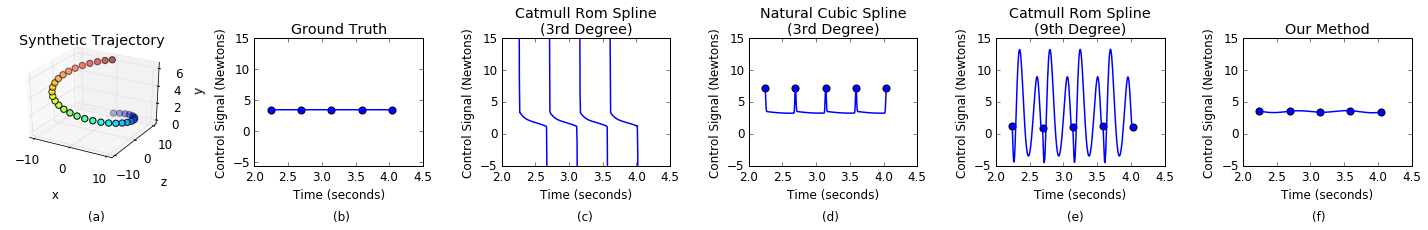

In [9]:
t_sparse_ind = clip(floor(t_sparse/dt).astype(int32),0,num_timesteps-1)

k = 357
kk = 5
ui = 0
lw = 1.5
ms = 50

fig = plt.figure(figsize=(20,3.2));

matplotlib.rcParams.update({'font.size': 12});

i = 30
ax = fig.add_subplot(161, projection="3d");
ax.locator_params(tight=True, nbins=5);
ax.set_title("Synthetic Trajectory");
ax.set_xlabel("\n\n x");
ax.set_zlabel("   y   ");
ax.set_ylabel("\n\n z");
ax.scatter(p_body_ground[::i,0], p_body_ground[::i,2], p_body_ground[::i,1], c=t[::i], cmap="jet", marker="o", s=40);

subplot(162);
title("Ground Truth");
ylabel("\n\nControl Signal (Newtons)");
xlabel("Time (seconds)\n");
plot(t[k:-k], u_ground[k:-k,ui],linewidth=lw);
scatter(t_sparse[kk:-kk],u_ground[t_sparse_ind[kk:-kk],ui],s=ms);
gca().set_ylim([-5.5, 15]);
gca().ticklabel_format(useOffset=False);

subplot(163);
title("Catmull Rom Spline\n(3rd Degree)");
ylabel("Control Signal (Newtons)");
xlabel("Time (seconds)");
u_tmp = u_catmull_rom_3[:,ui].copy();
u_tmp[gradient(u_tmp) > 20] = inf;
plot(t[k:-k], u_tmp[k:-k],linewidth=lw);
gca().set_ylim([-5, 15]);

subplot(164);
title("Natural Cubic Spline\n(3rd Degree)");
ylabel("Control Signal (Newtons)");
xlabel("Time (seconds)");
plot(t[k:-k], u_natural_cubic[k:-k,ui],linewidth=lw);
# make the keyframes look nicer
# scatter(t_sparse[kk:-kk],u_natural_cubic[t_sparse_ind[kk:-kk],ui],s=ms);
scatter(t_sparse[kk:-kk],u_natural_cubic[t_sparse_ind[kk],ui]*ones_like(t_sparse[kk:-kk])+0.5,s=ms);
gca().set_ylim([-5, 15]);

subplot(165);
title("Catmull Rom Spline\n(9th Degree)");
ylabel("Control Signal (Newtons)");
xlabel("Time (seconds)");
plot(t[k:-k], u_catmull_rom_9[k:-k,ui],linewidth=lw);
scatter(t_sparse[kk:-kk],u_catmull_rom_9[t_sparse_ind[kk:-kk],ui],s=ms);
gca().set_ylim([-5, 15]);

subplot(166);
title("Our Method");
ylabel("Control Signal (Newtons)");
xlabel("Time (seconds)");
plot(t[k:-k], u_mv_7_d4[k:-k,ui],linewidth=lw);
scatter(t_sparse[kk:-kk],u_mv_7_d4[t_sparse_ind[kk:-kk],ui],s=ms);
gca().set_ylim([-5, 15]);

fig.tight_layout();

figtext(.065, 0.02, "(a)");
figtext(.235, 0.02, "(b)");
figtext(.405, 0.02, "(c)");
figtext(.575, 0.02, "(d)");
figtext(.745, 0.02, "(e)");
figtext(.915, 0.02, "(f)");

savefig("../plots/00/evaluating_different_interpolation_methods.pdf");